# Baseline Model

# Spectral Hashing with HOG Example, load

In [1]:
"""
We will be using Spectral hashing to generate hash codes based on Image data from mnist. 

"""

'\nWe will be using Spectral hashing to generate hash codes based on Image data from mnist. \n\n'

In [2]:
# Cook
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import pandas as pd


In [3]:
# Load MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:

x_train,y_train = x_train[0:10000],y_train[0:10000]
x_test,y_test = x_test[0:4000],y_test[0:4000]


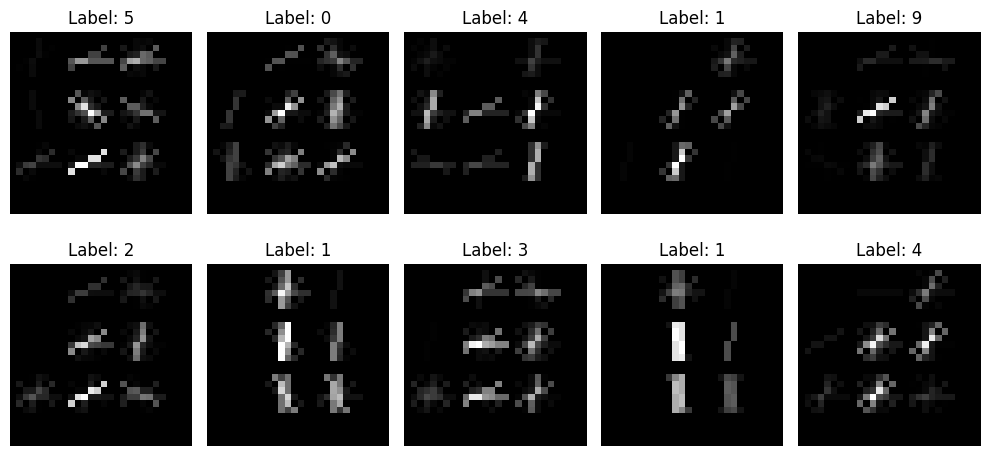

In [5]:

# Function to extract HOG features
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    
    for image in images:
        # Compute HOG features
        fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(3, 3), visualize=True) # multichannel=False 
                                            # !!!! We might need to tune these!!!
        hog_features.append(fd)
        hog_images.append(hog_image)
    
    return np.array(hog_features), np.array(hog_images)

# Extract HOG features for training and testing data
x_train_hog, x_train_hog_images = extract_hog_features(x_train)
x_test_hog, x_test_hog_images = extract_hog_features(x_test)

# Visualize some HOG images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_hog_images[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Spectral Hashing

In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import numpy as np


In [7]:
x_train_hog.shape

(10000, 81)

In [8]:
"""
# Normalize features
scaler = StandardScaler()
train_hog = scaler.fit_transform(x_train_hog)
test_hog = scaler.transform(x_test_hog)
""" 
# -> Not doing this because HOG is SCALED LOCALLY!!!



'\n# Normalize features\nscaler = StandardScaler()\ntrain_hog = scaler.fit_transform(x_train_hog)\ntest_hog = scaler.transform(x_test_hog)\n'

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.decomposition import PCA


# Assuming train_hog and test_hog are your datasets with shape (60000, 9, 9) and (10000, 9, 9)

# Flatten the datasets

train_hog_flat = x_train_hog.reshape(x_train_hog.shape[0], -1)  # Shape: (60000, 81)
test_hog_flat = x_test_hog.reshape(x_test_hog.shape[0], -1)    # Shape: (10000, 81)

#

In [10]:
train_hog_flat.shape

(10000, 81)

In [11]:
len(train_hog_flat[0])

81

In [12]:
"""
# Step 1: Apply PCA on training set and transform both train and test sets
def apply_pca(train_hog, test_hog, n_components):
    pca = PCA(n_components=n_components)
    
    # Fit PCA on the training set and transform it
    reduced_train = pca.fit_transform(train_hog)
    
    # Apply the same PCA transformation to the test set (without fitting again)
    reduced_test = pca.transform(test_hog)
    
    explained_variance = np.sum(pca.explained_variance_ratio_) * 100
    print(f"PCA reduced to {n_components} dimensions, explained variance: {explained_variance:.2f}%")

    return reduced_train, reduced_test

# Example usage
n_components = 40  # Choose the number of components to reduce to (tune this)
train_hog_flat, test_hog_flat = apply_pca(train_hog_flat, test_hog_flat, n_components=n_components)
"""
# PCA IS likely unnecessary after HOG, because noise etc should have been removed. 

'\n# Step 1: Apply PCA on training set and transform both train and test sets\ndef apply_pca(train_hog, test_hog, n_components):\n    pca = PCA(n_components=n_components)\n    \n    # Fit PCA on the training set and transform it\n    reduced_train = pca.fit_transform(train_hog)\n    \n    # Apply the same PCA transformation to the test set (without fitting again)\n    reduced_test = pca.transform(test_hog)\n    \n    explained_variance = np.sum(pca.explained_variance_ratio_) * 100\n    print(f"PCA reduced to {n_components} dimensions, explained variance: {explained_variance:.2f}%")\n\n    return reduced_train, reduced_test\n\n# Example usage\nn_components = 40  # Choose the number of components to reduce to (tune this)\ntrain_hog_flat, test_hog_flat = apply_pca(train_hog_flat, test_hog_flat, n_components=n_components)\n'

In [13]:
import scipy
from sklearn.neighbors import NearestNeighbors


In [14]:
#AdjacencyMatrix = scipy.spatial.distance.cdist(pca_features_train, pca_features_train, metric = 'euclidean')
#Adj_test = scipy.spatial.distance.cdist(pca_features_test, pca_features_test, metric = 'euclidean')

In [15]:

# Assuming pca_features_train is your feature matrix after applying PCA
n_neighbors = 20  # You can adjust k here

# Step 1: Fit k-NN
knn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn.fit(train_hog_flat)

# Step 2: Compute the k-neighbors graph (Adjacency Matrix)
# kneighbors_graph returns a sparse matrix with 1s indicating neighbors
AdjacencyMatrix_train = knn.kneighbors_graph(train_hog_flat, mode='connectivity').toarray()


In [16]:
# Skal vi have en seperat en for test???? probably ja

# Step 1: Fit k-NN
knn_x = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
knn_x.fit(test_hog_flat)

# Step 2: Compute the k-neighbors graph (Adjacency Matrix)
# kneighbors_graph returns a sparse matrix with 1s indicating neighbors
AdjacencyMatrix_test = knn_x.kneighbors_graph(test_hog_flat, mode='connectivity').toarray()


# Kør videre

In [17]:
def check_adjacency_matrix(adj_mat):
    """
    Check if the adjacency matrix has entries for all rows
    """

    # Assuming BinaryAdjacencyMatrix is your n x n binary matrix
    row_sums = adj_mat.sum(axis=1)
    
    # Find rows where the sum is greater than 1
    valid_rows = np.where(row_sums > 1)[0]  # Rows with more than 1 connection
    invalid_rows = np.where(row_sums == 1)[0]  # Rows with only self-connections

    # Print the number of valid and invalid rows
    print(f"Number of rows with connections > 1: {len(valid_rows)}")
    print(f"Number of rows with only self-connections (sum = 1): {len(invalid_rows)}")

    # If you want to list which rows have invalid connections:
    print("Rows with only self-connections:", invalid_rows)

In [18]:
AdjacencyMatrix_train = AdjacencyMatrix_train- np.identity(len(AdjacencyMatrix_train))
AdjacencyMatrix_test = AdjacencyMatrix_test- np.identity(len(AdjacencyMatrix_test))

In [19]:
AdjacencyMatrix_train.sum()

190000.0

In [20]:
# Function to calculate intra-label distances, Not necessary 
"""
def compute_intra_label_distances(AdjacencyMatrix, labels):
    unique_labels = np.unique(labels)
    intra_label_stats = {}

    for label in unique_labels:
        # Get the indices of samples that have the current label
        label_indices = np.where(labels == label)[0]
        
        # Extract the sub-matrix corresponding to this label
        label_distance_matrix = AdjacencyMatrix[np.ix_(label_indices, label_indices)]
        
        # Calculate statistics (mean, median, variance)
        mean_distance = np.mean(label_distance_matrix)
        median_distance = np.median(label_distance_matrix)
        variance_distance = np.var(label_distance_matrix)

        # Store the statistics
        intra_label_stats[label] = {
            'mean': mean_distance,
            'median': median_distance,
            'variance': variance_distance
        }

        # Output the stats
        print(f"Label {label}: Mean Distance: {mean_distance:.4f}, Median Distance: {median_distance:.4f}, Variance: {variance_distance:.4f}")
    
    return intra_label_stats
"""
# Example usage
#intra_label_distances = compute_intra_label_distances(AdjacencyMatrix, y_train[0:10000])

'\ndef compute_intra_label_distances(AdjacencyMatrix, labels):\n    unique_labels = np.unique(labels)\n    intra_label_stats = {}\n\n    for label in unique_labels:\n        # Get the indices of samples that have the current label\n        label_indices = np.where(labels == label)[0]\n        \n        # Extract the sub-matrix corresponding to this label\n        label_distance_matrix = AdjacencyMatrix[np.ix_(label_indices, label_indices)]\n        \n        # Calculate statistics (mean, median, variance)\n        mean_distance = np.mean(label_distance_matrix)\n        median_distance = np.median(label_distance_matrix)\n        variance_distance = np.var(label_distance_matrix)\n\n        # Store the statistics\n        intra_label_stats[label] = {\n            \'mean\': mean_distance,\n            \'median\': median_distance,\n            \'variance\': variance_distance\n        }\n\n        # Output the stats\n        print(f"Label {label}: Mean Distance: {mean_distance:.4f}, Median D

In [21]:
def adj_matrix_to_hash_codes(adj_matrix, n_bits = 32):
    # Convert to sparse matrix format
    W = csr_matrix(adj_matrix)
    # Compute the degree matrix for the test set
    print("sparse matrix done")
    D = np.diag(np.array(W.sum(axis=1)).flatten())
    print("D matrix done")
    # Compute the graph Laplacian for the test set
    L = D - W
    print("calculated Laplacian")
    # Ensure L is symmetric
    #L = (L + L.T) / 2 # burde ikke være required (burde være symmetrisk by default)
    # Compute the smallest eigenvectors of the Laplacian
    #n_bits = 32  # Number of bits in the hash code
    _, eigenvectors = eigsh(L, k=n_bits, which='SM', maxiter=1000, tol=1e-3) # Fjerner den trivielle løsning ?? , k = antal eigenvektorer
    print("calculated eigenvectors")
    # Binarize the eigenvectors to form the hash codes
    hash_codes = (eigenvectors > 0).astype(int)

    # Output the generated hash codes
    print("Generated hash codes:")
    return hash_codes


In [22]:
hash_codes_train = adj_matrix_to_hash_codes(AdjacencyMatrix_train,32)
hash_codes_test = adj_matrix_to_hash_codes(AdjacencyMatrix_test,32)


sparse matrix done
D matrix done
calculated Laplacian
calculated eigenvectors
Generated hash codes:
sparse matrix done
D matrix done
calculated Laplacian
calculated eigenvectors
Generated hash codes:


In [23]:
len(np.unique(hash_codes_train,axis = 0 ))
# This is ok, collisions occur, but at a high rate, so there are maybe some problems... 

5574

In [24]:
len(np.unique(hash_codes_test,axis = 0))

3056

In [25]:
import json

In [26]:
hash_codes_train
hash_codes_test

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 1, 1]])

In [27]:
# Example: hash_codes is your NumPy array of shape (10000, 32)
# Convert hash codes to a list
hash_codes_train_list = hash_codes_train.tolist()  # Convert to a regular list

# Define the file name
json_file_name = r'C:\Users\Test\Desktop\p7\Spectral\hash_codes\hash_codes_train_newest.json'

# Save to a JSON file
with open(json_file_name, 'w') as json_file:
    json.dump(hash_codes_train_list, json_file)

hash_codes_test_list = hash_codes_test.tolist()
# Define the file name
json_file_name = r'C:\Users\Test\Desktop\p7\Spectral\hash_codes\hash_codes_test_newest.json'

# Save to a JSON file
with open(json_file_name, 'w') as json_file:
    json.dump(hash_codes_test_list, json_file)







### EVALUATION OF HOG

In [28]:
# Using nearest neigbors (KNN)
"""
from sklearn.neighbors import NearestNeighbors
import numpy as np

def average_precision_at_k(retrieved_labels, true_label, k):
    #Calculates the average precision at k for a single query.
    correct = 0
    precision_at_i = []
    
    for i in range(1, k + 1):
        if retrieved_labels[i - 1] == true_label:
            correct += 1
            precision_at_i.append(correct / i)
    
    if len(precision_at_i) == 0:
        return 0
    return np.mean(precision_at_i)

def mean_average_precision(train_hash_codes, train_labels, test_hash_codes, test_labels, k):
    #Calculates MAP at k using k-NN retrieval.
    # Fit k-NN on the train hash codes
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(train_hash_codes)
    
    # Find k nearest neighbors for each test sample
    distances, indices = knn.kneighbors(test_hash_codes)

    # Calculate average precision for each test sample
    ap_scores = []
    
    for i in range(len(test_labels)):
        # Get the labels of the k nearest neighbors
        retrieved_labels = train_labels[indices[i]]
        true_label = test_labels[i]
        
        # Compute average precision for the current test sample
        ap = average_precision_at_k(retrieved_labels, true_label, k)
        ap_scores.append(ap)
    
    # Return mean average precision
    return np.mean(ap_scores)

# Example usage:
# Assuming hash_codes_train, y_train, hash_codes_test, y_test are your hash codes and labels
pre_at_k = []
for k in range(1,100): # Top k neighbors to consider
    map_score = mean_average_precision(hash_codes_train, y_train, hash_codes_test, y_test, k)
    pre_at_k.append(map_score)
print(f"Mean Average Precision (MAP) at {k}: {map_score:.4f}")
"""

'\nfrom sklearn.neighbors import NearestNeighbors\nimport numpy as np\n\ndef average_precision_at_k(retrieved_labels, true_label, k):\n    #Calculates the average precision at k for a single query.\n    correct = 0\n    precision_at_i = []\n    \n    for i in range(1, k + 1):\n        if retrieved_labels[i - 1] == true_label:\n            correct += 1\n            precision_at_i.append(correct / i)\n    \n    if len(precision_at_i) == 0:\n        return 0\n    return np.mean(precision_at_i)\n\ndef mean_average_precision(train_hash_codes, train_labels, test_hash_codes, test_labels, k):\n    #Calculates MAP at k using k-NN retrieval.\n    # Fit k-NN on the train hash codes\n    knn = NearestNeighbors(n_neighbors=k, metric=\'euclidean\')\n    knn.fit(train_hash_codes)\n    \n    # Find k nearest neighbors for each test sample\n    distances, indices = knn.kneighbors(test_hash_codes)\n\n    # Calculate average precision for each test sample\n    ap_scores = []\n    \n    for i in range(len

In [29]:
import numpy as np
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [30]:
import numpy as np
from scipy.spatial.distance import cdist

def average_precision_at_k(retrieved_labels, true_label):
    """Calculates the average precision for a single query based on retrieved labels."""
    correct = 0
    precision_at_i = []
    
    for i in range(1, len(retrieved_labels) + 1):
        if retrieved_labels[i - 1] == true_label:
            correct += 1
            precision_at_i.append(correct / i)
    
    if len(precision_at_i) == 0:
        return 0
    return np.mean(precision_at_i)

def map_at_single_threshold(train_hash_codes, train_labels, test_hash_codes, test_labels, threshold):
    """Calculates MAP for a given distance threshold."""
    
    # Calculate the distance matrix between test and train hash codes
    distances = cdist(test_hash_codes, test_hash_codes, metric='cityblock')
    
    ap_scores = []
    
    for i in range(len(test_labels)):
        # Get distances and corresponding labels for the i-th test sample
        test_distances = distances[i]
        
        # Retrieve indices of training samples within the current threshold distance
        retrieved_indices = np.where(test_distances <= threshold)[0]
        
        if len(retrieved_indices) == 0:
            # If no neighbors are found within the distance threshold, skip this test sample
            continue
        
        # Get the labels of the retrieved neighbors
        retrieved_labels = train_labels[retrieved_indices]
        true_label = test_labels[i]
        
        # Compute average precision for the current test sample
        ap = average_precision_at_k(retrieved_labels, true_label)
        ap_scores.append(ap)
    
    # Compute mean average precision (MAP)
    if len(ap_scores) == 0:
        return 0  # No valid samples for this threshold
    return np.mean(ap_scores)

# Example usage:




In [34]:
map_at_single_threshold(hash_codes_test,y_test,hash_codes_test,y_test,1)

0.9805723555369408

In [32]:
def map(eigenvectors_bin, labels, k):
    labels_dic = {i:0 for i in range(10)}
    labels_size_dic = {i:0 for i in range(10)}
    for i, eigenvector in enumerate(tqdm(eigenvectors_bin)):
        tp = 0
        fp = 0
        for j, eigenvector2 in enumerate(eigenvectors_bin):
            if np.abs(eigenvector - eigenvector2).sum() <= k: # Manhattan? 
                if labels[i] == labels[j]:
                    tp += 1
                else:
                    fp += 1
        labels_dic[labels[i]] += tp/(tp+fp)
        labels_size_dic[labels[i]] += 1
    ap_dic = {i:labels_dic[i]/labels_size_dic[i] for i in range(10)}
    map_value = np.array(list(ap_dic.values())).mean()
    return map_value

In [35]:
map(hash_codes_test, y_test, 1)

  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [00:31<00:00, 126.86it/s]


0.971830704215231

In [103]:
# Set the distance threshold to 2
#threshold = 0.9
maps = []
t = 0
for t in range(30):
# Assuming hash_codes_train, y_train, hash_codes_test, y_test are defined
    map_score = map_at_single_threshold(hash_codes_train, y_train, hash_codes_test, y_test, t)
    maps.append(map_score)
    t += 0.1

#print(f"Mean Average Precision (MAP) at distance {threshold}: {map_score:.4f}")

KeyboardInterrupt: 

In [ ]:
maps

In [59]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def knn_with_tie_breaking_matrix(neighbor_matrix, distance_matrix):
    # Function to perform tie-breaking with distance for a single row of neighbors
    def classify_single_row(neighbors, distances):
        # Step 1: Count occurrences of each label
        label_counts = Counter(neighbors)
        
        # Step 2: Find the most common label(s)
        max_count = max(label_counts.values())
        candidates = [label for label, count in label_counts.items() if count == max_count]
        
        # Step 3: If no tie, return the most common label
        if len(candidates) == 1:
            return candidates[0]
        
        # Step 4: If there's a tie, break it by choosing the label of the closest neighbor
        closest_index = np.argmin([distances[i] for i in range(len(neighbors)) if neighbors[i] in candidates])
        return neighbors[closest_index]

    # Apply the classification function to each row of the matrix
    most_common_labels = np.array([classify_single_row(neighbors, distances) 
                                   for neighbors, distances in zip(neighbor_matrix, distance_matrix)])
    
    return most_common_labels


In [66]:

# Benchmarking Retrieval Accuracy
def retrieval_accuracy(train_hash_codes, train_labels, test_hash_codes, test_labels):
    # Use k-NN on train hash codes
    knn_retrieval = NearestNeighbors(n_neighbors=5)
    knn_retrieval.fit(train_hash_codes)  # Fit on the train hash codes
    
    # Find nearest neighbors for each test sample in the train set
    distances, indices = knn_retrieval.kneighbors(test_hash_codes)
    


# Classify using tie-breaking with distance
    result = knn_with_tie_breaking_matrix(neighbor_matrix = indices, distance_matrix = distances)

    most_common_labels = train_labels[result]

    print(most_common_labels)


    # Calculate accuracy based on comparison with the test labels
    accuracy = np.mean(most_common_labels == test_labels) * 100

    cm = confusion_matrix(test_labels, most_common_labels)

    print("Confusion Matrix:")
    print(cm)
    macro_precision = precision_score(test_labels, most_common_labels, average= "macro")
    macro_recall = recall_score(test_labels, most_common_labels, average = "macro")
    micro_precision = precision_score(test_labels, most_common_labels, average= "micro")
    micro_recall = recall_score(test_labels, most_common_labels, average = "micro")


    print("Macro precision: ", macro_precision)
    print("Macro recall: ", macro_recall)
    print("Micro precision: ", micro_precision)
    print("Micro recall: ", micro_recall)


    return accuracy


accuracy = retrieval_accuracy(hash_codes_train,y_train, hash_codes_test, y_test)
print(f"Retrieval Accuracy: {accuracy:.2f}%")


[6 9 8 ... 8 4 8]
Confusion Matrix:
[[ 69  64  24  82 152 100  74 138 168 109]
 [ 69  46 142 116 155 135 154 160  58 100]
 [ 53 125 152  79 112 108 100 108 117  78]
 [103  98  69 103 114  74 133 154  77  85]
 [ 82  84 128  81  84 125  77 111 130  80]
 [ 58 115  64 140  85 112 128  90  60  40]
 [ 74  42 198 162  60  86  63  87  95  91]
 [ 78  89 112 112  77  70  72 191 147  80]
 [113  70  65  57 119 126 117 150  92  65]
 [ 35 147  57 131  85 111  90 140  75 138]]
Macro precision:  0.10368841838503165
Macro recall:  0.10540886703323915
Micro precision:  0.105
Micro recall:  0.105
Retrieval Accuracy: 10.50%


# Evaluation

In [48]:
# PRecision @ K

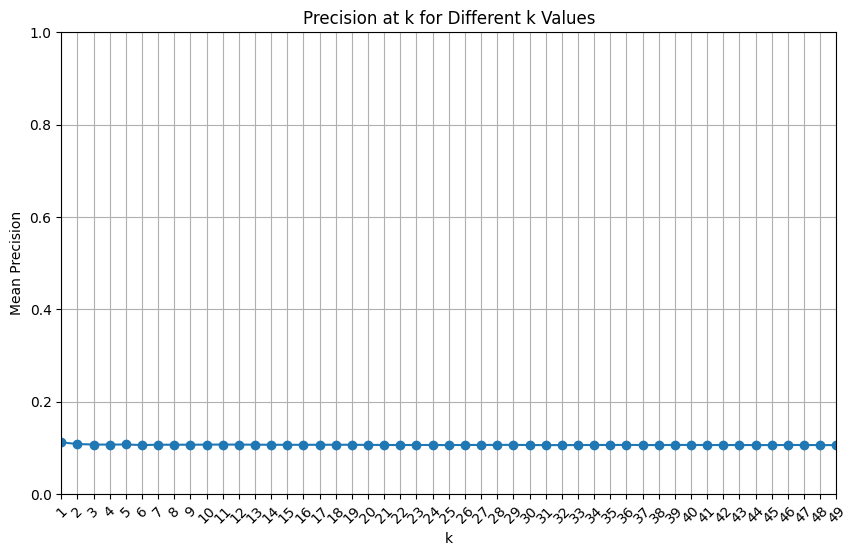

In [128]:
hash_codes_hog

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 0],
       [0, 1, 1, ..., 0, 1, 0]])

In [ ]:
# Mean average precision

In [ ]:
# I hope this is good. 

# Raw images

In [31]:
import numpy as np
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images: shape becomes (60000, 784) and (10000, 784)
train_images = x_train.reshape(x_train.shape[0], -1)  # Shape: (60000, 784)
test_images = x_test.reshape(x_test.shape[0], -1)      # Shape: (10000, 784)

# Build a k-NN graph using the training set
n_neighbors = 5
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(test_images)  # Fit k-NN on the training set

# Generate the adjacency matrix for the test set based on its own k-NN graph
W = knn.kneighbors_graph(test_images, mode='connectivity')

# Convert to sparse matrix format
W = csr_matrix(W)

# Compute the degree matrix for the test set
D = np.diag(np.array(W.sum(axis=1)).flatten())

# Compute the graph Laplacian for the test set
L = D - W
L = (L + L.T) / 2  # Ensure the matrix is symmetric

# Compute the smallest eigenvectors of the Laplacian
n_bits = 32  # Number of bits in the hash code
_, eigenvectors = eigsh(L, k=n_bits, which='SM')

# Binarize the eigenvectors to form the hash codes
hash_codes_raw = (eigenvectors > 0).astype(int)

In [38]:
import json

# Example: hash_codes is your NumPy array of shape (10000, 32)
# Convert hash codes to a list
hash_codes_list = hash_codes_raw.tolist()  # Convert to a regular list

# Define the file name
json_file_name = r'C:\Users\Test\Desktop\p7\Spectral\hash_codes_raw\hash_codes.json'

# Save to a JSON file
with open(json_file_name, 'w') as json_file:
    json.dump(hash_codes_list, json_file)

print(f"Hash codes saved to {json_file_name}")

Hash codes saved to C:\Users\Test\Desktop\p7\Spectral\hash_codes_raw\hash_codes.json


In [2]:
hash_codes_raw

NameError: name 'hash_codes_raw' is not defined

In [34]:

accuracy = retrieval_accuracy(hash_codes_raw, y_test)
print(f"Retrieval Accuracy for raw data: {accuracy:.2f}%")


Retrieval Accuracy for raw data: 98.87%


In [ ]:
# Calculate accuracies for different k values
accuracies = retrieval_accuracy(hash_codes_raw, y_test, k_values)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(accuracies.keys(), accuracies.values(), marker='o')
plt.title('Retrieval Accuracy vs. k-NN Value')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Retrieval Accuracy (%)')
plt.xticks(k_values)  # Show all k values on x-axis
plt.grid()
plt.xlim(1, 51)
plt.ylim(0, 100)
plt.show()


In [33]:
# IDEAS FOR VALIDATION: 
# - k means (centroids,medoids, etc.)
# - KNN for the hash codes ( with incrementing k, should also tell how good the clustering)

# Validation

In [9]:
import json
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [6]:
# Now that we have the two hash tables, and the belonging y_test values, we can start validating
# Load MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [8]:
# Loading hash_hog, hash_raw, and y_test (response var)
y_test


array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
# Load the hash codes from JSON files
def load_hash_codes(file_path):
    with open(file_path, 'r') as f:
        hash_codes = json.load(f)
    return np.array(hash_codes)


# Load the hash codes
raw_hash_codes = load_hash_codes(r"C:\Users\Test\Desktop\p7\Spectral\hash_codes\hash_codes.json")
hog_hash_codes = load_hash_codes(r"C:\Users\Test\Desktop\p7\Spectral\hash_codes\hash_codes_hog.json")

Clustering for raw hash codes:
Clustering evaluation (kmeans):
Adjusted Rand Index (ARI): 0.0805
Normalized Mutual Information (NMI): 0.1689
Silhouette Score: 0.0587

Clustering for HOG-based hash codes:
Clustering evaluation (kmeans):
Adjusted Rand Index (ARI): 0.1007
Normalized Mutual Information (NMI): 0.1842
Silhouette Score: 0.0606


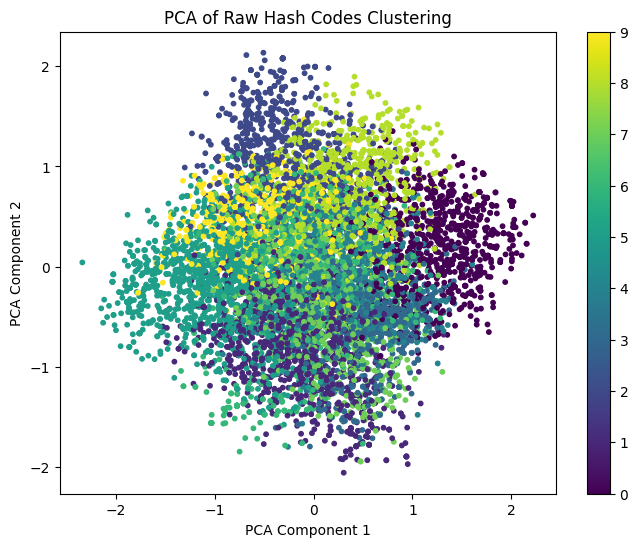

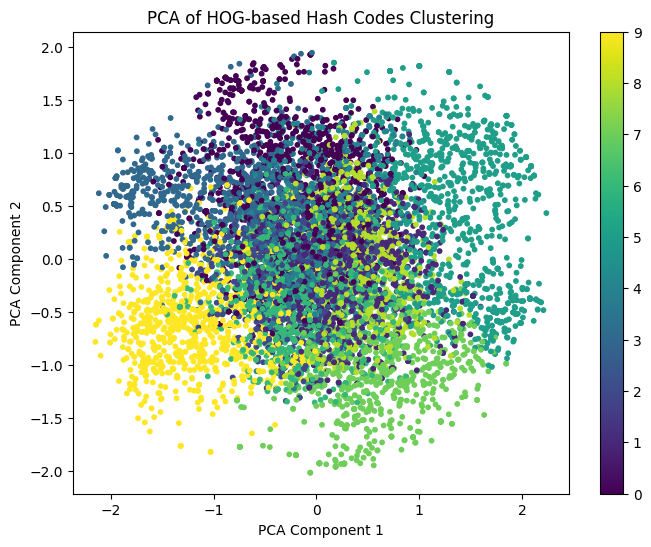

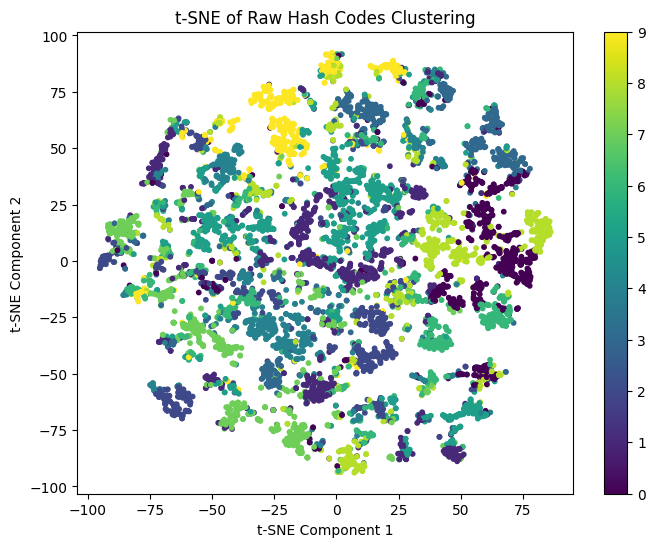

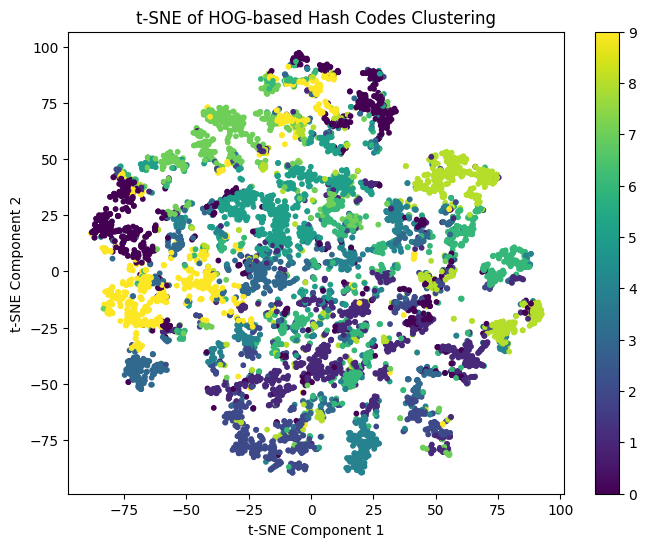

In [11]:

# Assume y_test is already loaded as part of the MNIST dataset
# y_test should be a numpy array of the true labels

# Perform clustering with K-Means (you can also try DBSCAN)
def perform_clustering_and_evaluate(hash_codes, y_test, method='kmeans', n_clusters=10):
    if method == 'kmeans':
        # Apply K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(hash_codes)
    elif method == 'dbscan':
        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        clusters = dbscan.fit_predict(hash_codes)

    # Evaluate clustering
    ari = adjusted_rand_score(y_test, clusters)
    nmi = normalized_mutual_info_score(y_test, clusters)
    silhouette = silhouette_score(hash_codes, clusters)
    
    print(f"Clustering evaluation ({method}):")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    
    return clusters

# Evaluate clustering on raw and HOG-based hash codes
print("Clustering for raw hash codes:")
raw_clusters = perform_clustering_and_evaluate(raw_hash_codes, y_test)

print("\nClustering for HOG-based hash codes:")
hog_clusters = perform_clustering_and_evaluate(hog_hash_codes, y_test)

# Visualization with PCA (optional)
def plot_pca_clusters(hash_codes, clusters, title):
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(hash_codes)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar()
    plt.show()

# Visualize the clusters with PCA
plot_pca_clusters(raw_hash_codes, raw_clusters, 'PCA of Raw Hash Codes Clustering')
plot_pca_clusters(hog_hash_codes, hog_clusters, 'PCA of HOG-based Hash Codes Clustering')

# You can also use t-SNE for better visualization
def plot_tsne_clusters(hash_codes, clusters, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(hash_codes)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=10)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar()
    plt.show()

# Visualize the clusters with t-SNE
plot_tsne_clusters(raw_hash_codes, raw_clusters, 't-SNE of Raw Hash Codes Clustering')
plot_tsne_clusters(hog_hash_codes, hog_clusters, 't-SNE of HOG-based Hash Codes Clustering')

In [13]:
from sklearn.metrics import pairwise_distances
from collections import defaultdict

# Perform clustering with DBSCAN and evaluate intra-cluster variance
def perform_dbscan_and_evaluate(hash_codes, y_test, eps=0.5, min_samples=5):
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(hash_codes)
    
    # Exclude noise points (labeled as -1 by DBSCAN)
    valid_indices = clusters != -1
    valid_clusters = clusters[valid_indices]
    valid_hash_codes = hash_codes[valid_indices]
    valid_y_test = y_test[valid_indices]
    
    # Evaluate clustering performance (on valid points)
    ari = adjusted_rand_score(valid_y_test, valid_clusters)
    nmi = normalized_mutual_info_score(valid_y_test, valid_clusters)
    silhouette = silhouette_score(valid_hash_codes, valid_clusters)
    
    print(f"DBSCAN Clustering Evaluation:")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    
    # Calculate intra-cluster variance
    intra_cluster_variances = calculate_intra_cluster_variance(valid_hash_codes, valid_clusters)
    print("\nIntra-cluster variances:")
    for cluster_id, variance in intra_cluster_variances.items():
        print(f"Cluster {cluster_id}: Variance = {variance:.4f}")
    
    return clusters

# Intra-cluster variance calculation
def calculate_intra_cluster_variance(hash_codes, clusters):
    cluster_points = defaultdict(list)
    
    # Group points by cluster
    for i, cluster_id in enumerate(clusters):
        cluster_points[cluster_id].append(hash_codes[i])
    
    # Calculate variance for each cluster
    cluster_variances = {}
    for cluster_id, points in cluster_points.items():
        points_array = np.array(points)
        if len(points_array) > 1:
            variance = np.mean(np.var(points_array, axis=0))  # Variance across dimensions
        else:
            variance = 0.0  # If only one point in the cluster, variance is 0
        cluster_variances[cluster_id] = variance
    
    return cluster_variances


# Apply DBSCAN and evaluate for raw hash codes
print("DBSCAN on raw hash codes:")
raw_clusters = perform_dbscan_and_evaluate(raw_hash_codes, y_test, eps=0.5, min_samples=5)

# Apply DBSCAN and evaluate for HOG-based hash codes
print("\nDBSCAN on HOG-based hash codes:")
hog_clusters = perform_dbscan_and_evaluate(hog_hash_codes, y_test, eps=0.5, min_samples=5)

DBSCAN on raw hash codes:
DBSCAN Clustering Evaluation:
Adjusted Rand Index (ARI): 0.0860
Normalized Mutual Information (NMI): 0.5941
Silhouette Score: 1.0000

Intra-cluster variances:
Cluster 0: Variance = 0.0000
Cluster 1: Variance = 0.0000
Cluster 2: Variance = 0.0000
Cluster 3: Variance = 0.0000
Cluster 4: Variance = 0.0000
Cluster 5: Variance = 0.0000
Cluster 6: Variance = 0.0000
Cluster 7: Variance = 0.0000
Cluster 8: Variance = 0.0000
Cluster 9: Variance = 0.0000
Cluster 10: Variance = 0.0000
Cluster 11: Variance = 0.0000
Cluster 12: Variance = 0.0000
Cluster 13: Variance = 0.0000
Cluster 14: Variance = 0.0000
Cluster 15: Variance = 0.0000
Cluster 16: Variance = 0.0000
Cluster 17: Variance = 0.0000
Cluster 18: Variance = 0.0000
Cluster 19: Variance = 0.0000
Cluster 20: Variance = 0.0000
Cluster 21: Variance = 0.0000
Cluster 22: Variance = 0.0000
Cluster 23: Variance = 0.0000
Cluster 24: Variance = 0.0000
Cluster 25: Variance = 0.0000
Cluster 26: Variance = 0.0000
Cluster 27: Var

K-Means Clustering on Raw Hash Codes:


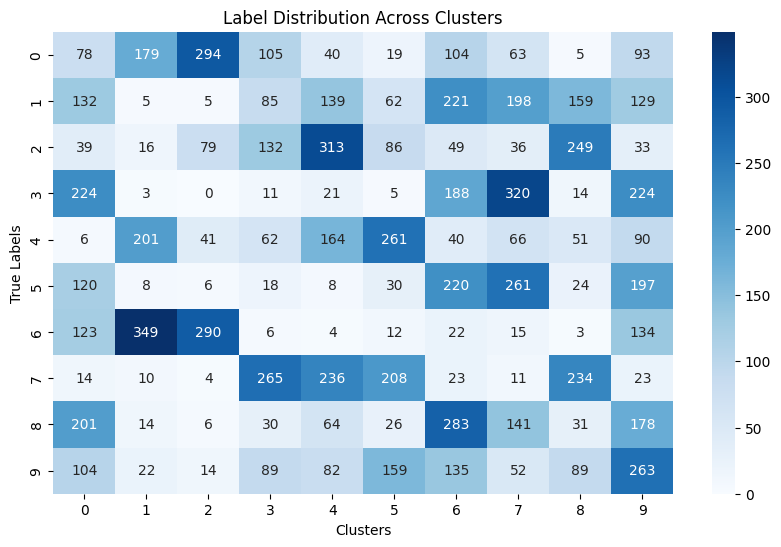


K-Means Clustering on HOG-based Hash Codes:


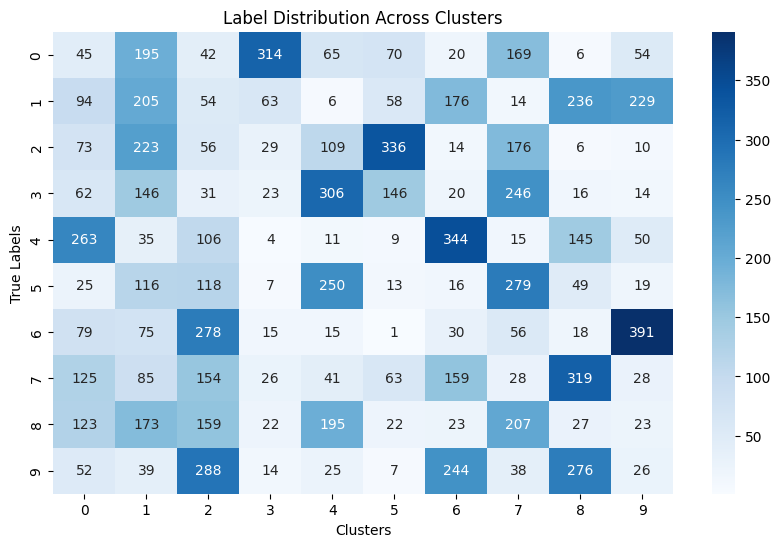

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()

# Load hash codes and true labels
# Assuming you have already loaded raw_hash_codes, hog_hash_codes, and y_test

# Apply K-Means clustering on raw hash codes
print("K-Means Clustering on Raw Hash Codes:")
raw_clusters = kmeans_clustering(raw_hash_codes, n_clusters=10)

# Step 2: Build the label-cluster matrix
raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, y_test)

# Step 3: Plot the heatmap for raw hash codes
plot_heatmap(raw_label_cluster_matrix)

# You can repeat the process for HOG-based hash codes if needed:
print("\nK-Means Clustering on HOG-based Hash Codes:")
hog_clusters = kmeans_clustering(hog_hash_codes, n_clusters=10)

# Step 2: Build the label-cluster matrix for HOG
hog_label_cluster_matrix = build_label_cluster_matrix(hog_clusters, y_test)

# Step 3: Plot the heatmap for HOG-based hash codes
plot_heatmap(hog_label_cluster_matrix)

K-Means Clustering on Raw Pixel Data:


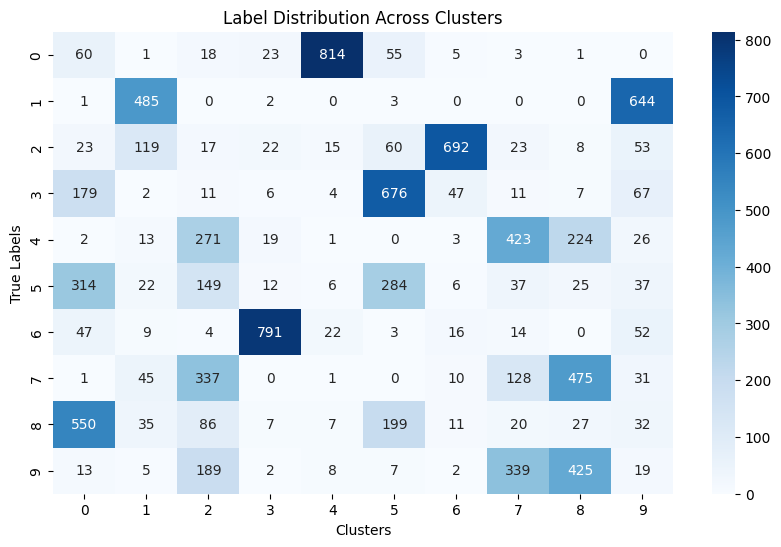

In [17]:
# Load the MNIST raw data (flattened)
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images from 28x28 into 784-dimensional vectors
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

# Step 1: Perform K-Means clustering on raw pixel data
print("K-Means Clustering on Raw Pixel Data:")
raw_data_clusters = kmeans_clustering(x_test_flattened, n_clusters=10)

# Step 2: Build the label-cluster matrix for raw data
raw_data_label_cluster_matrix = build_label_cluster_matrix(raw_data_clusters, y_test)

# Step 3: Plot the heatmap for raw pixel data
plot_heatmap(raw_data_label_cluster_matrix)

In [ ]:
# Results, raw pixel data without Spectral hashing seems to get a lot more uniform clusters 
# 

# SIFT (to be done)

In [ ]:
# NOW DOING THE SAME FOR SIFT, 
# WE NEED AN EXTRA STEP OF PREPROCESSING, DUE TO SIFT CREATING 60000 X 5 X 128 LIST OF LISTS FOR TRAINING, 

In [ ]:
# Initialize SIFT
sift = cv2.SIFT_create()
def apply_sift(images):
    sift_features = []
    keypoints_list = []
    for img in images[:5]:  # Only process first 5 records
        # Convert to uint8 format for OpenCV
        img = img.astype(np.uint8)
        # Detect keypoints and descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        
        if descriptors is not None:
            sift_features.append(descriptors)
        else:
            sift_features.append(np.array([]))
        
        keypoints_list.append(keypoints)
    
    return sift_features, keypoints_list

# Apply SIFT to the first 5 training images
sift_train_features, keypoints_train = apply_sift(x_train)

# Plot the first 5 images with their SIFT keypoints
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(x_train[i], keypoints_train[i], None, color=(0, 255, 0))
    
    # Display the image with keypoints
    axs[i].imshow(img_with_keypoints, cmap='gray')
    axs[i].set_title(f"Label: {y_train[i]}")
    axs[i].axis('off')

plt.show()

In [ ]:
# SIFT


# Initialize SIFT
sift = cv2.SIFT_create()

def apply_sift(images):
    sift_features = []
    for img in images:
        # Convert to uint8 format for OpenCV
        img = img.astype(np.uint8)
        # Detect keypoints and descriptors using SIFT
        keypoints, descriptors = sift.detectAndCompute(img, None)
        
        if descriptors is not None:
            sift_features.append(descriptors)
        else:
            # If no descriptors are found, we append an empty array
            sift_features.append(np.array([]))

    return sift_features

# Apply SIFT to training and testing images
sift_train_features = apply_sift(x_train)
sift_test_features = apply_sift(x_test)

# Check results for first image
print("First image SIFT descriptors shape:", sift_train_features[0].shape)

In [ ]:
all_descriptors = []

for descriptors in sift_train_features:
    if descriptors is not None and len(descriptors) > 0:
        # Ensure each descriptor is in 2D form (if not already)
        all_descriptors.append(np.array(descriptors))

# Stack all descriptors into a single 2D array
if len(all_descriptors) > 0:
    all_descriptors = np.vstack(all_descriptors)
else:
    raise ValueError("No valid SIFT descriptors found in the dataset.")

# Get total number of SIFT descriptors
n_descriptors = all_descriptors.shape[0]

# Ensure n_clusters is less than or equal to number of descriptors
n_clusters = min(50, n_descriptors)

# Cluster SIFT descriptors using k-Means to form visual words (codebook)
kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans.fit(all_descriptors)

# Convert each image's descriptors into a histogram of visual words
def descriptors_to_histogram(descriptors, kmeans):
    hist = np.zeros(n_clusters)
    if descriptors is not None and len(descriptors) > 0:
        # Ensure descriptors are a 2D array
        descriptors = np.array(descriptors)
        cluster_assignments = kmeans.predict(descriptors)
        for cluster in cluster_assignments:
            hist[cluster] += 1
    return hist

# Apply to train and test sets
train_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_train_features])
test_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_test_features])

In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
import numpy as np

# Number of nearest neighbors
n_neighbors = 5

# Build k-NN graph on the training set
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(train_histograms)  # train_histograms from SIFT features

# Generate the adjacency matrix for the test set
# 'connectivity' mode gives a sparse matrix indicating k-nearest neighbors
W = knn.kneighbors_graph(test_histograms, mode='connectivity')

# Convert to a square matrix by making the adjacency matrix symmetric
W = 0.5 * (W + W.T)  # Ensure symmetry, making it square (n_samples, n_samples)

# Convert to sparse matrix format for efficient computation
W = csr_matrix(W)

# Compute the degree matrix (sum of each row in W)
D = np.diag(np.array(W.sum(axis=1)).flatten())

# Compute the graph Laplacian: L = D - W
L = D - W

# Compute the smallest eigenvectors of the Laplacian
n_bits = 32  # Number of bits in the hash code
_, eigenvectors = eigsh(L, k=n_bits, which='SM')

# Binarize the eigenvectors to form the hash codes
hash_codes = (eigenvectors > 0).astype(int)

# Output the generated hash code
print("Generated hash codes:")
print(hash_codes)

# YADA

In [24]:
from sklearn.cluster import MiniBatchKMeans

# Suppose sift_train_features is a list of SIFT descriptors for each image
all_descriptors = np.vstack(sift_train_features)  # Stack all SIFT descriptors from training set

# Cluster SIFT descriptors using k-Means to form visual words (codebook)
n_clusters = 20  # Number of visual words (codebook size)
kmeans = MiniBatchKMeans(n_clusters=n_clusters)
kmeans.fit(all_descriptors)

# Convert each image's descriptors into a histogram of visual words
def descriptors_to_histogram(descriptors, kmeans):
    hist = np.zeros(n_clusters)
    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for cluster in cluster_assignments:
            hist[cluster] += 1
    return hist

train_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_train_features])
test_histograms = np.array([descriptors_to_histogram(d, kmeans) for d in sift_test_features])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [14]:
from scipy.spatial.distance import cdist


In [52]:
z = len(set(str(x) for x in list(hash_codes)))
z

283

In [53]:

# Compute Manhattan (L1) distance between all pairs of hash codes
manhattan_distances = cdist(hash_codes, hash_codes, metric='cityblock')


In [54]:

# Number of nearest neighbors to check
n_neighbors = 5

# Initialize list to store whether the closest neighbors share the same label
same_label_count = 0
total_neighbors = 0

# Loop through each hash code and find its closest neighbors
for i in range(len(hash_codes)):
    # Get indices of the nearest neighbors (excluding itself)
    nearest_neighbors = np.argsort(manhattan_distances[i])[1:n_neighbors+1]  # Skip the first (itself)
    
    # Compare labels of nearest neighbors
    for neighbor in nearest_neighbors:
        if y_test[i] == y_test[neighbor]:
            same_label_count += 1
        total_neighbors += 1

# Calculate the percentage of nearest neighbors with the same label
accuracy = same_label_count / total_neighbors * 100
print(f"Percentage of nearest hash codes with the same label: {accuracy:.2f}%")

Percentage of nearest hash codes with the same label: 69.67%


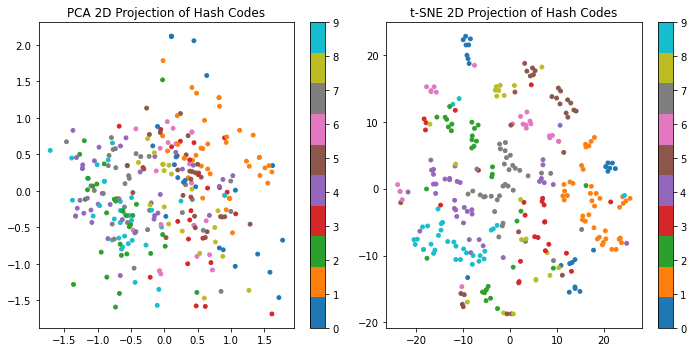

In [59]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce dimensionality using PCA (to 2 dimensions)
pca = PCA(n_components=2)
hash_codes_2d_pca = pca.fit_transform(hash_codes)

# Reduce dimensionality using t-SNE (for comparison, to 2 dimensions)
tsne = TSNE(n_components=2, random_state=42)
hash_codes_2d_tsne = tsne.fit_transform(hash_codes)

# Plot the 2D PCA projection
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(hash_codes_2d_pca[:, 0], hash_codes_2d_pca[:, 1], c=y_test[0:300], cmap='tab10', s=15)
plt.colorbar()
plt.title("PCA 2D Projection of Hash Codes")

# Plot the 2D t-SNE projection
plt.subplot(1, 2, 2)
plt.scatter(hash_codes_2d_tsne[:, 0], hash_codes_2d_tsne[:, 1], c=y_test[0:300], cmap='tab10', s=15)
plt.colorbar()
plt.title("t-SNE 2D Projection of Hash Codes")

plt.tight_layout()
plt.show()

In [55]:
y_test[0:100]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=uint8)

In [56]:
z

283

In [57]:
hash_codes[0]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

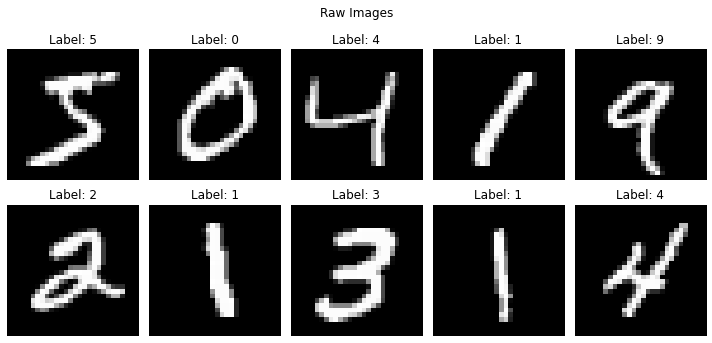

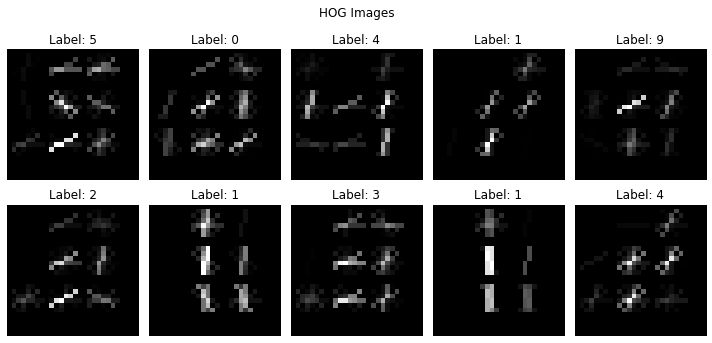

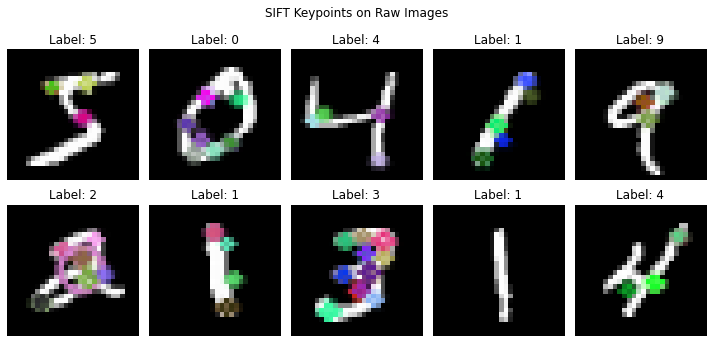

In [12]:

# 3. SIFT FEATURES
def extract_sift_features(images):
    sift = cv2.SIFT_create()  # Create SIFT object
    sift_features = []
    for image in images:
        # Convert image to the format OpenCV expects
        image = np.uint8(image)
        keypoints, descriptors = sift.detectAndCompute(image, None)
        
        # If descriptors are None (no keypoints), just create an empty array
        if descriptors is None:
            descriptors = np.zeros((1, 128))
        
        # Some images will have more keypoints than others, so we pad/truncate to 128 descriptors
        if descriptors.shape[0] < 128:
            descriptors = np.pad(descriptors, ((0, 128 - descriptors.shape[0]), (0, 0)), mode='constant')
        else:
            descriptors = descriptors[:128]
        
        sift_features.append(descriptors.flatten())
    
    return np.array(sift_features)

# Extract SIFT features for training and testing data
x_train_sift = extract_sift_features(x_train)
x_test_sift = extract_sift_features(x_test)

# VISUALIZATION OF RAW, HOG, AND SIFT FEATURES

# Display some raw images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Raw Images")
plt.tight_layout()
plt.show()

# Visualize some HOG images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_hog_images[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("HOG Images")
plt.tight_layout()
plt.show()

# Visualizing SIFT keypoints on original images
plt.figure(figsize=(10, 5))
for i in range(10):
    img = np.uint8(x_train[i])
    keypoints = cv2.SIFT_create().detect(img, None)
    img_sift = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_sift, cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("SIFT Keypoints on Raw Images")
plt.tight_layout()
plt.show()

# Now you have extracted raw, HOG, and SIFT features.
# x_train_raw, x_train_hog, and x_train_sift contain the respective features

In [ ]:
x_train_hog[0]